In [6]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [7]:
train_data = pd.read_csv('../datasets/horse_health/train.csv')
test_data = pd.read_csv('../datasets/horse_health/test.csv')
origin = pd.read_csv('../datasets/horse_health/horse.csv')
sample_submission = pd.read_csv('../datasets/horse_health/sample_submission.csv')

In [8]:
train_data["is_generated"] = 1
test_data["is_generated"] = 1
origin["is_generated"] = 0

train_data.drop('id', axis=1, inplace=True)
test_data.drop('id', axis=1, inplace=True)

total = pd.concat([train_data, origin], ignore_index=True)
total.drop_duplicates(inplace=True)

target = 'outcome'
total[target] = total[target].apply(lambda x: 1 if x == 'euthanized' else 0 if x == 'died' else 2)


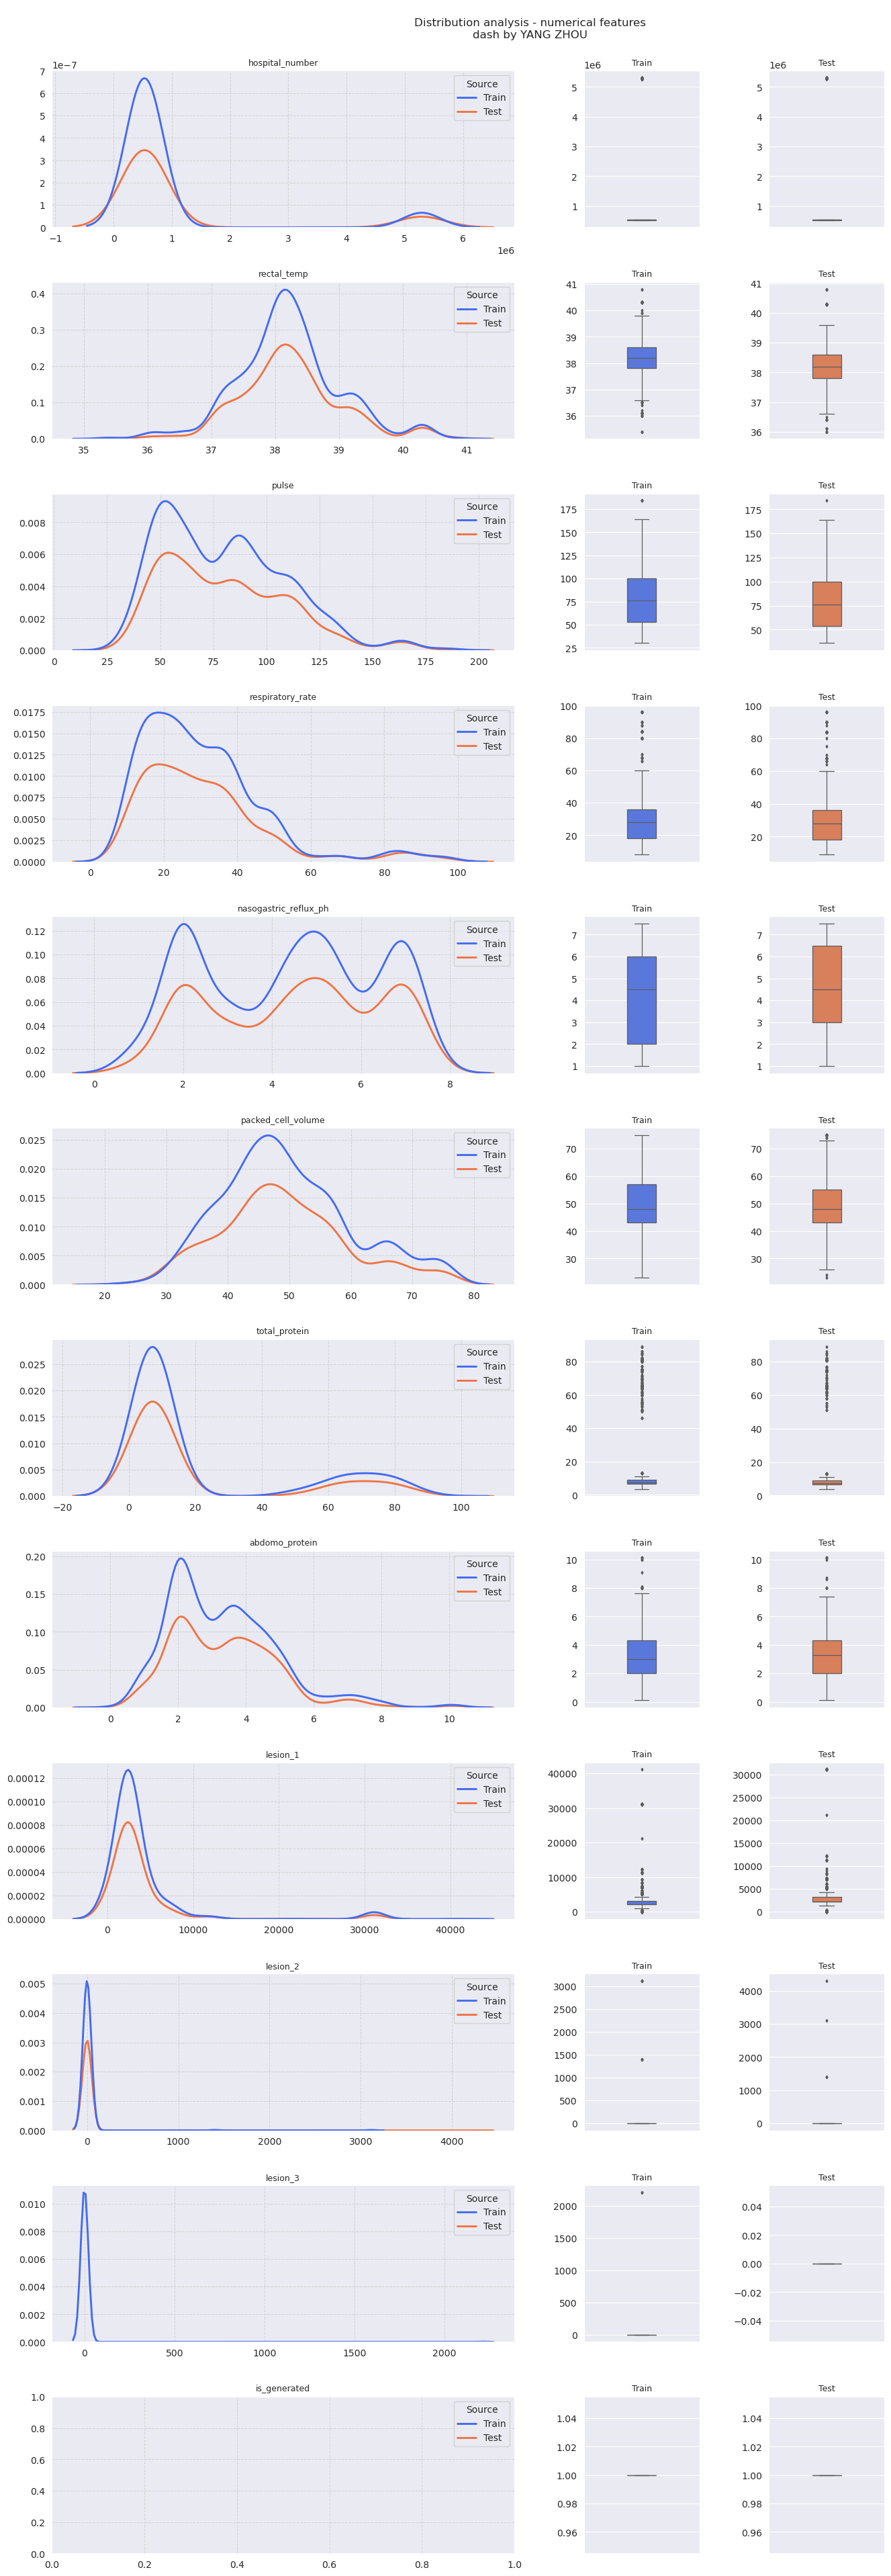

In [9]:
num = train_data.select_dtypes(include=['int64','float64']).columns

df = pd.concat([train_data[num].assign(Source = 'Train'), test_data[num].assign(Source = 'Test')], ignore_index = True)

# Use of more advanced artistic matplotlib interface (see the axes)
fig, axes = plt.subplots(len(num), 3 ,figsize = (16, len(num) * 4), gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]})

for i,col in enumerate(num):
    ax = axes[i,0]
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', palette=['#456cf0', '#ed7647'], linewidth = 2.1, warn_singular=False, ax = ax) # Use of seaborn with artistic interface
    ax.set_title(f"\n{col}",fontsize = 9)
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
    ax.set(xlabel = '', ylabel = '')

    ax = axes[i,1]
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#456cf0', ax = ax)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title("Train", fontsize = 9)

    ax = axes[i,2]
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#ed7647', ax = ax)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title("Test", fontsize = 9)

plt.suptitle(f'\nDistribution analysis - numerical features\ndash by YANG ZHOU\n',fontsize = 12, y = 0.9, x = 0.57)
plt.show()

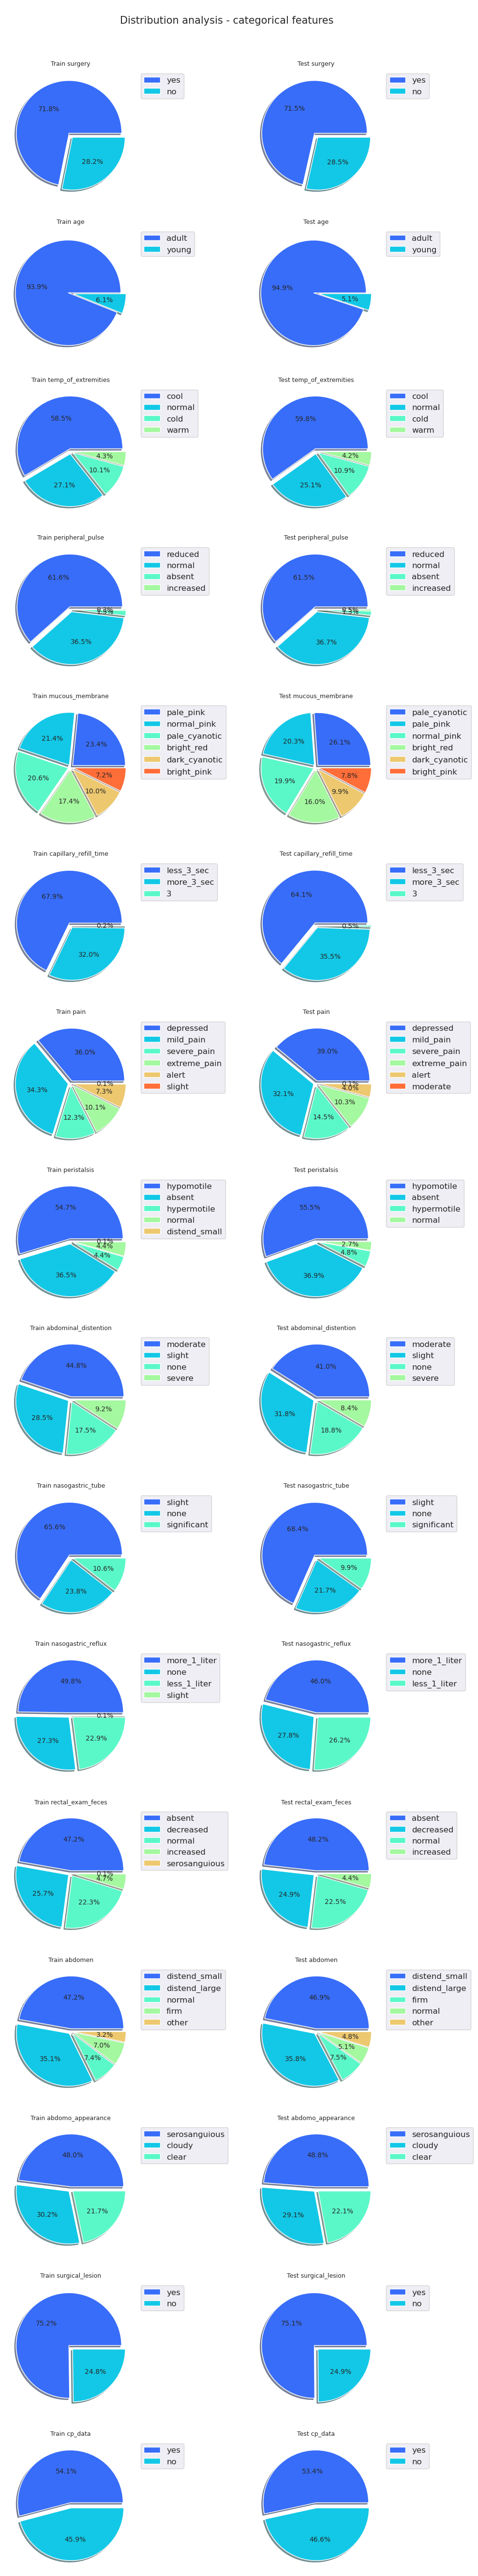

In [10]:
sns.set_palette('rainbow')

num = train_data.drop(columns='outcome').select_dtypes(include=['object']).columns

df = pd.concat([train_data[num].assign(Source = 'train'), 
                test_data[num].assign(Source = 'test')], 
               axis=0, ignore_index = True)

fig, axes = plt.subplots(len(num), 2 ,figsize = (12, len(num) * 4.2))

for i,col in enumerate(num):
    train_dist = df.loc[df.Source == 'train', [col]].value_counts()
    test_dist = df.loc[df.Source == 'test', [col]].value_counts()
    
    ax = axes[i,0]
    ax.pie(train_dist, shadow=True, explode=[.05]*len(train_dist), autopct='%.1f%%')
    ax.legend([category[0] for category in train_dist.index], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title(f'Train {col}',fontsize = 9)

    ax = axes[i,1]
    ax.pie(test_dist, shadow=True, explode=[.05]*len(test_dist), autopct='%.1f%%')
    ax.legend([category[0] for category in test_dist.index], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title(f'Test {col}',fontsize = 9)


plt.suptitle(f"\nDistribution analysis - categorical features\n",fontsize = 15, y = 0.9, x = 0.57)
plt.show()